In [ ]:
!python -m pip cache purge
!python -m pip install numpy pandas seaborn matplotlib tqdm statsmodels scikit-learn --timeout 300


Files removed: 48
     -----------------------                  7.5/13.0 MB ? eta -:--:--


ERROR: Wheel 'numpy' located at C:\Users\User\AppData\Local\Temp\pip-unpack-vqty0wph\numpy-2.3.1-cp311-cp311-win_amd64.whl is invalid.

[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


: 

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import rc
from pylab import rcParams
plt.style.use('fivethirtyeight')
from tensorflow.keras.models import Model
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
%matplotlib inline
%config InlineBackend. figure_format='retina'
sns.set(style='darkgrid', palette='muted', font_scale=1.2, rc={"axes.facecolor": "#2E2E2E", "axes.grid": True, "grid.color": "#333333", "axes.edgecolor": "#424242"})
color_pal = ['#FF6E40', '#FFEA00', '#1DE9B6', '#00E5FF', '#D500F9']
sns.set_palette(sns.color_palette(color_pal))
rcParams['figure.figsize' ] = 14, 7
rcParams['text.color'] = 'black'       # Titles and text
rcParams['axes.labelcolor'] = 'white'  # Axis labels
rcParams['xtick.color'] = 'black'      # X-axis tick labels
rcParams['ytick.color'] = 'black'
tqdm. pandas ()

In [5]:
df = pd.read_csv("../Datasets/vmCloud_data.csv")
df.head()

,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,c5215826-6237-4a33-9312-72c1df909881,2023-01-25 09:10:54,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,2023-01-26 04:46:34,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,2023-01-13 23:39:47,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,e672e32f-c134-4fbc-992b-34eb63bef6bf,2023-02-09 11:45:49,54.488318,88.100960,NaN,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,f38b8b50-6926-4533-be4f-89ad11624071,2023-06-14 08:27:26,42.365480,NaN,NaN,359.451537,3361.0,55.307992,0.351907,NaN,medium,waiting


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['timestamp'] = df['timestamp'].ffill()
df = df.sort_values(by='timestamp').reset_index(drop=True)
# df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
# df['second'] = df['timestamp'].dt.second
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


In [7]:
df.columns
# df.task_type.unique()

Index(['vm_id', 'timestamp', 'cpu_usage', 'memory_usage', 'network_traffic',
       'power_consumption', 'num_executed_instructions', 'execution_time',
       'energy_efficiency', 'task_type', 'task_priority', 'task_status',
       'month', 'day', 'hour', 'minute', 'day_of_week', 'is_weekend'],
      dtype='object')

In [8]:
num_cols = ['cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption',
            'num_executed_instructions', 'execution_time', 'energy_efficiency']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Compute first-order difference for cpu_usage
df['diff_cpu'] = df['cpu_usage'].diff()

# Rolling window features
df['avg_diff_3d'] = df['diff_cpu'].rolling(window=3, min_periods=1).mean()
df['avg_diff_7d'] = df['diff_cpu'].rolling(window=7, min_periods=1).mean()

# Lag features
df['lag_1'] = df['cpu_usage'].shift(1)
df['lag_2'] = df['cpu_usage'].shift(2)
df['lag_7'] = df['cpu_usage'].shift(7)

# Rate of change
df['cpu_rate_of_change'] = df['cpu_usage'].pct_change()

# Exponential moving average
df['ema_7'] = df['cpu_usage'].ewm(span=7, adjust=False).mean()

# Maximum CPU usage in last 7 days
# df['max_last_7d'] = df['cpu_usage'].rolling(window=7).max()

# Trend & Seasonality decomposition
try:
    decomposed = seasonal_decompose(df['cpu_usage'].dropna(), model='additive', period=7)
    df['cpu_trend'] = decomposed.trend
    df['cpu_seasonal'] = decomposed.seasonal
except:
    df['cpu_trend'] = None
    df['cpu_seasonal'] = None
    
cat_cols = ['task_type', 'task_priority', 'task_status']
df[cat_cols] = df[cat_cols].fillna('unknown')
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder if needed for inverse transform later

In [9]:
df.head()

,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,...,diff_cpu,avg_diff_3d,avg_diff_7d,lag_1,lag_2,lag_7,cpu_rate_of_change,ema_7,cpu_trend,cpu_seasonal
0,17fa09d5-4039-4adf-b8c2-92eb116d940a,2023-01-01 00:00:09,50.054758,90.540824,845.326434,35.834837,6556.0,33.238281,0.451264,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.054758,NaN,-0.013210
1,a5ee77f0-5a60-474d-8a66-11bf38337326,2023-01-01 00:00:09,63.282078,49.976089,212.708467,358.127312,3983.0,45.302997,0.681050,1,...,13.227320,13.227320,13.227320,50.054758,NaN,NaN,0.264257,53.361588,NaN,0.022752
2,NaN,2023-01-01 00:00:15,30.719806,89.199261,604.263594,325.820755,5002.0,3.232369,0.992169,2,...,-32.562273,-9.667476,-9.667476,63.282078,50.054758,NaN,-0.514558,47.701142,NaN,-0.023041
3,2206b2b6-a41c-4755-93d9-2a1784ba66a9,2023-01-01 00:00:15,29.608038,58.788456,345.979118,202.838902,8774.0,40.734419,0.890145,3,...,-1.111768,-6.815573,-6.815573,30.719806,63.282078,NaN,-0.036191,43.177866,54.272909,0.014835
4,fe5e04e3-4ea4-48cf-a193-3f58abd147ed,2023-01-01 00:00:31,14.019569,74.367251,600.520958,368.735533,8240.0,50.742393,0.639539,2,...,-15.588469,-16.420837,-9.008797,29.608038,30.719806,NaN,-0.526495,35.888292,57.698848,0.003952


In [10]:
df = df[['month','day', 'hour', 'minute', 'day_of_week','is_weekend','network_traffic','power_consumption', 'num_executed_instructions', 
         'execution_time','energy_efficiency', 'task_type', 'task_priority', 'task_status','cpu_usage', 'memory_usage','avg_diff_3d', 'avg_diff_7d', 
         'lag_1', 'lag_2', 'lag_7','cpu_rate_of_change', 'ema_7', 'cpu_trend', 'cpu_seasonal','diff_cpu',]];
df.columns

Index(['month', 'day', 'hour', 'minute', 'day_of_week', 'is_weekend',
       'network_traffic', 'power_consumption', 'num_executed_instructions',
       'execution_time', 'energy_efficiency', 'task_type', 'task_priority',
       'task_status', 'cpu_usage', 'memory_usage', 'avg_diff_3d',
       'avg_diff_7d', 'lag_1', 'lag_2', 'lag_7', 'cpu_rate_of_change', 'ema_7',
       'cpu_trend', 'cpu_seasonal', 'diff_cpu'],
      dtype='object')

In [11]:
df.dropna(inplace=True)

In [12]:
split_ind = int(len(df)*0.8)
train_df, test_df = df[:split_ind].copy(), df[split_ind:].copy()
print(train_df.shape, test_df.shape)

(1599992, 26) (399998, 26)


In [13]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

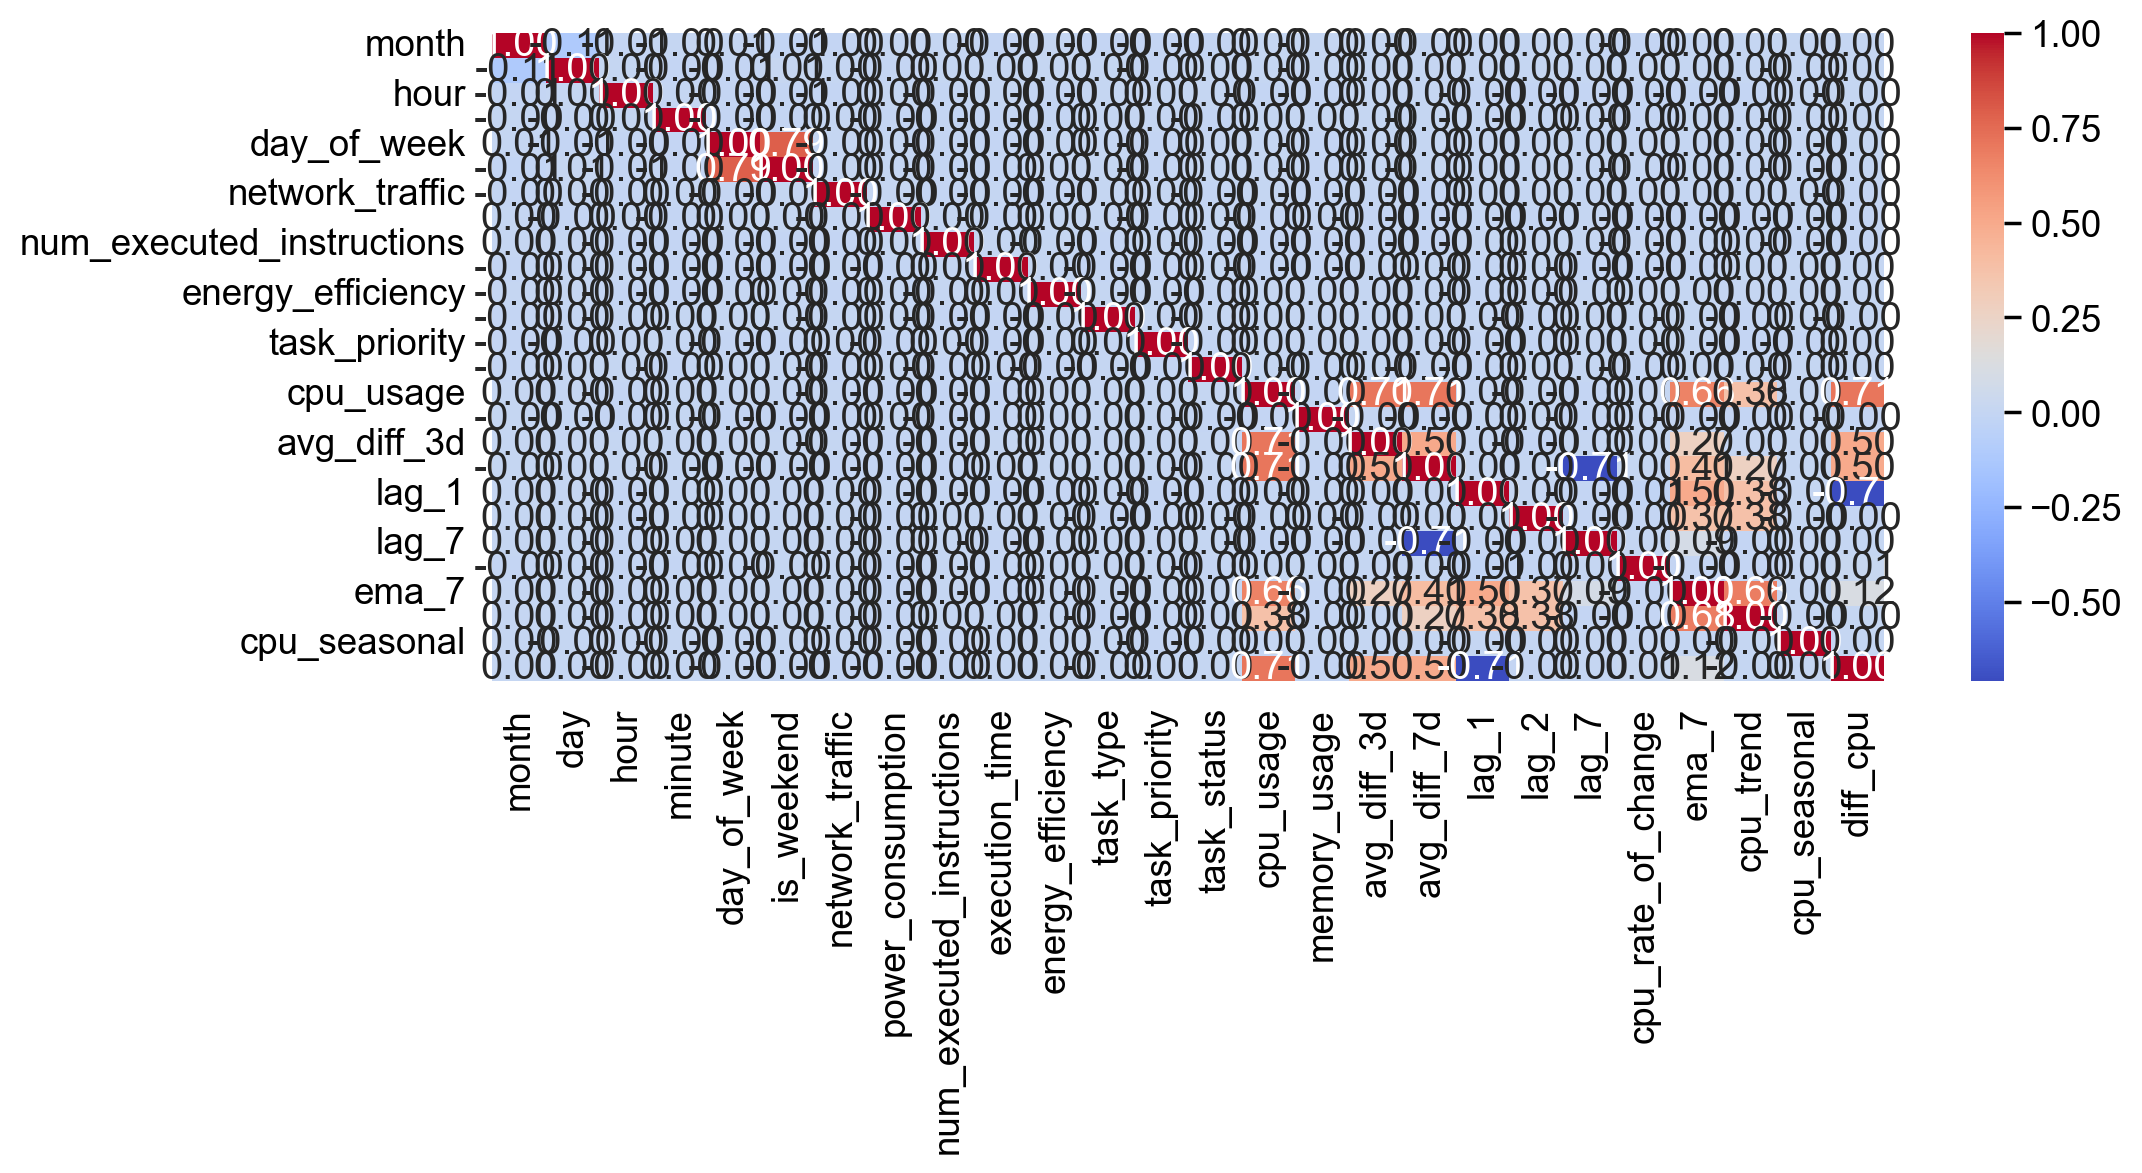

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = train_df.corr()
plt.figure(figsize=(10, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [15]:
scaler = MinMaxScaler((0,1))
columns_to_scale = ['network_traffic','power_consumption', 'num_executed_instructions', 
         'execution_time','energy_efficiency', 'task_type', 'task_priority', 'task_status','cpu_usage', 'memory_usage','avg_diff_3d', 'avg_diff_7d', 
         'lag_1', 'lag_2', 'lag_7','cpu_rate_of_change', 'ema_7', 'cpu_trend', 'cpu_seasonal','diff_cpu']
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()
train_df_scaled[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
test_df_scaled[columns_to_scale] = scaler.fit_transform(test_df[columns_to_scale])

# train_df_scaled = train_df_scaled[columns_to_scale]
# test_df_scaled = test_df_scaled[columns_to_scale]
train_df_scaled.head(3)

,month,day,hour,minute,day_of_week,is_weekend,network_traffic,power_consumption,num_executed_instructions,execution_time,...,avg_diff_3d,avg_diff_7d,lag_1,lag_2,lag_7,cpu_rate_of_change,ema_7,cpu_trend,cpu_seasonal,diff_cpu
7,1,1,0,1,6,1,0.253404,0.126914,0.500250,0.421612,...,0.800160,0.620058,0.990775,0.931486,0.500547,0.000001,0.699104,0.711776,0.397205,0.374357
8,1,1,0,1,6,1,0.353858,0.541505,0.623062,0.336165,...,0.324223,0.473590,0.740363,0.990775,0.632821,0.000001,0.675819,0.727795,0.747109,0.419581
9,1,1,0,1,6,1,0.453161,0.620155,0.840384,0.141462,...,0.453946,0.796355,0.580294,0.740363,0.307198,0.000002,0.760035,0.655652,0.301550,0.659195


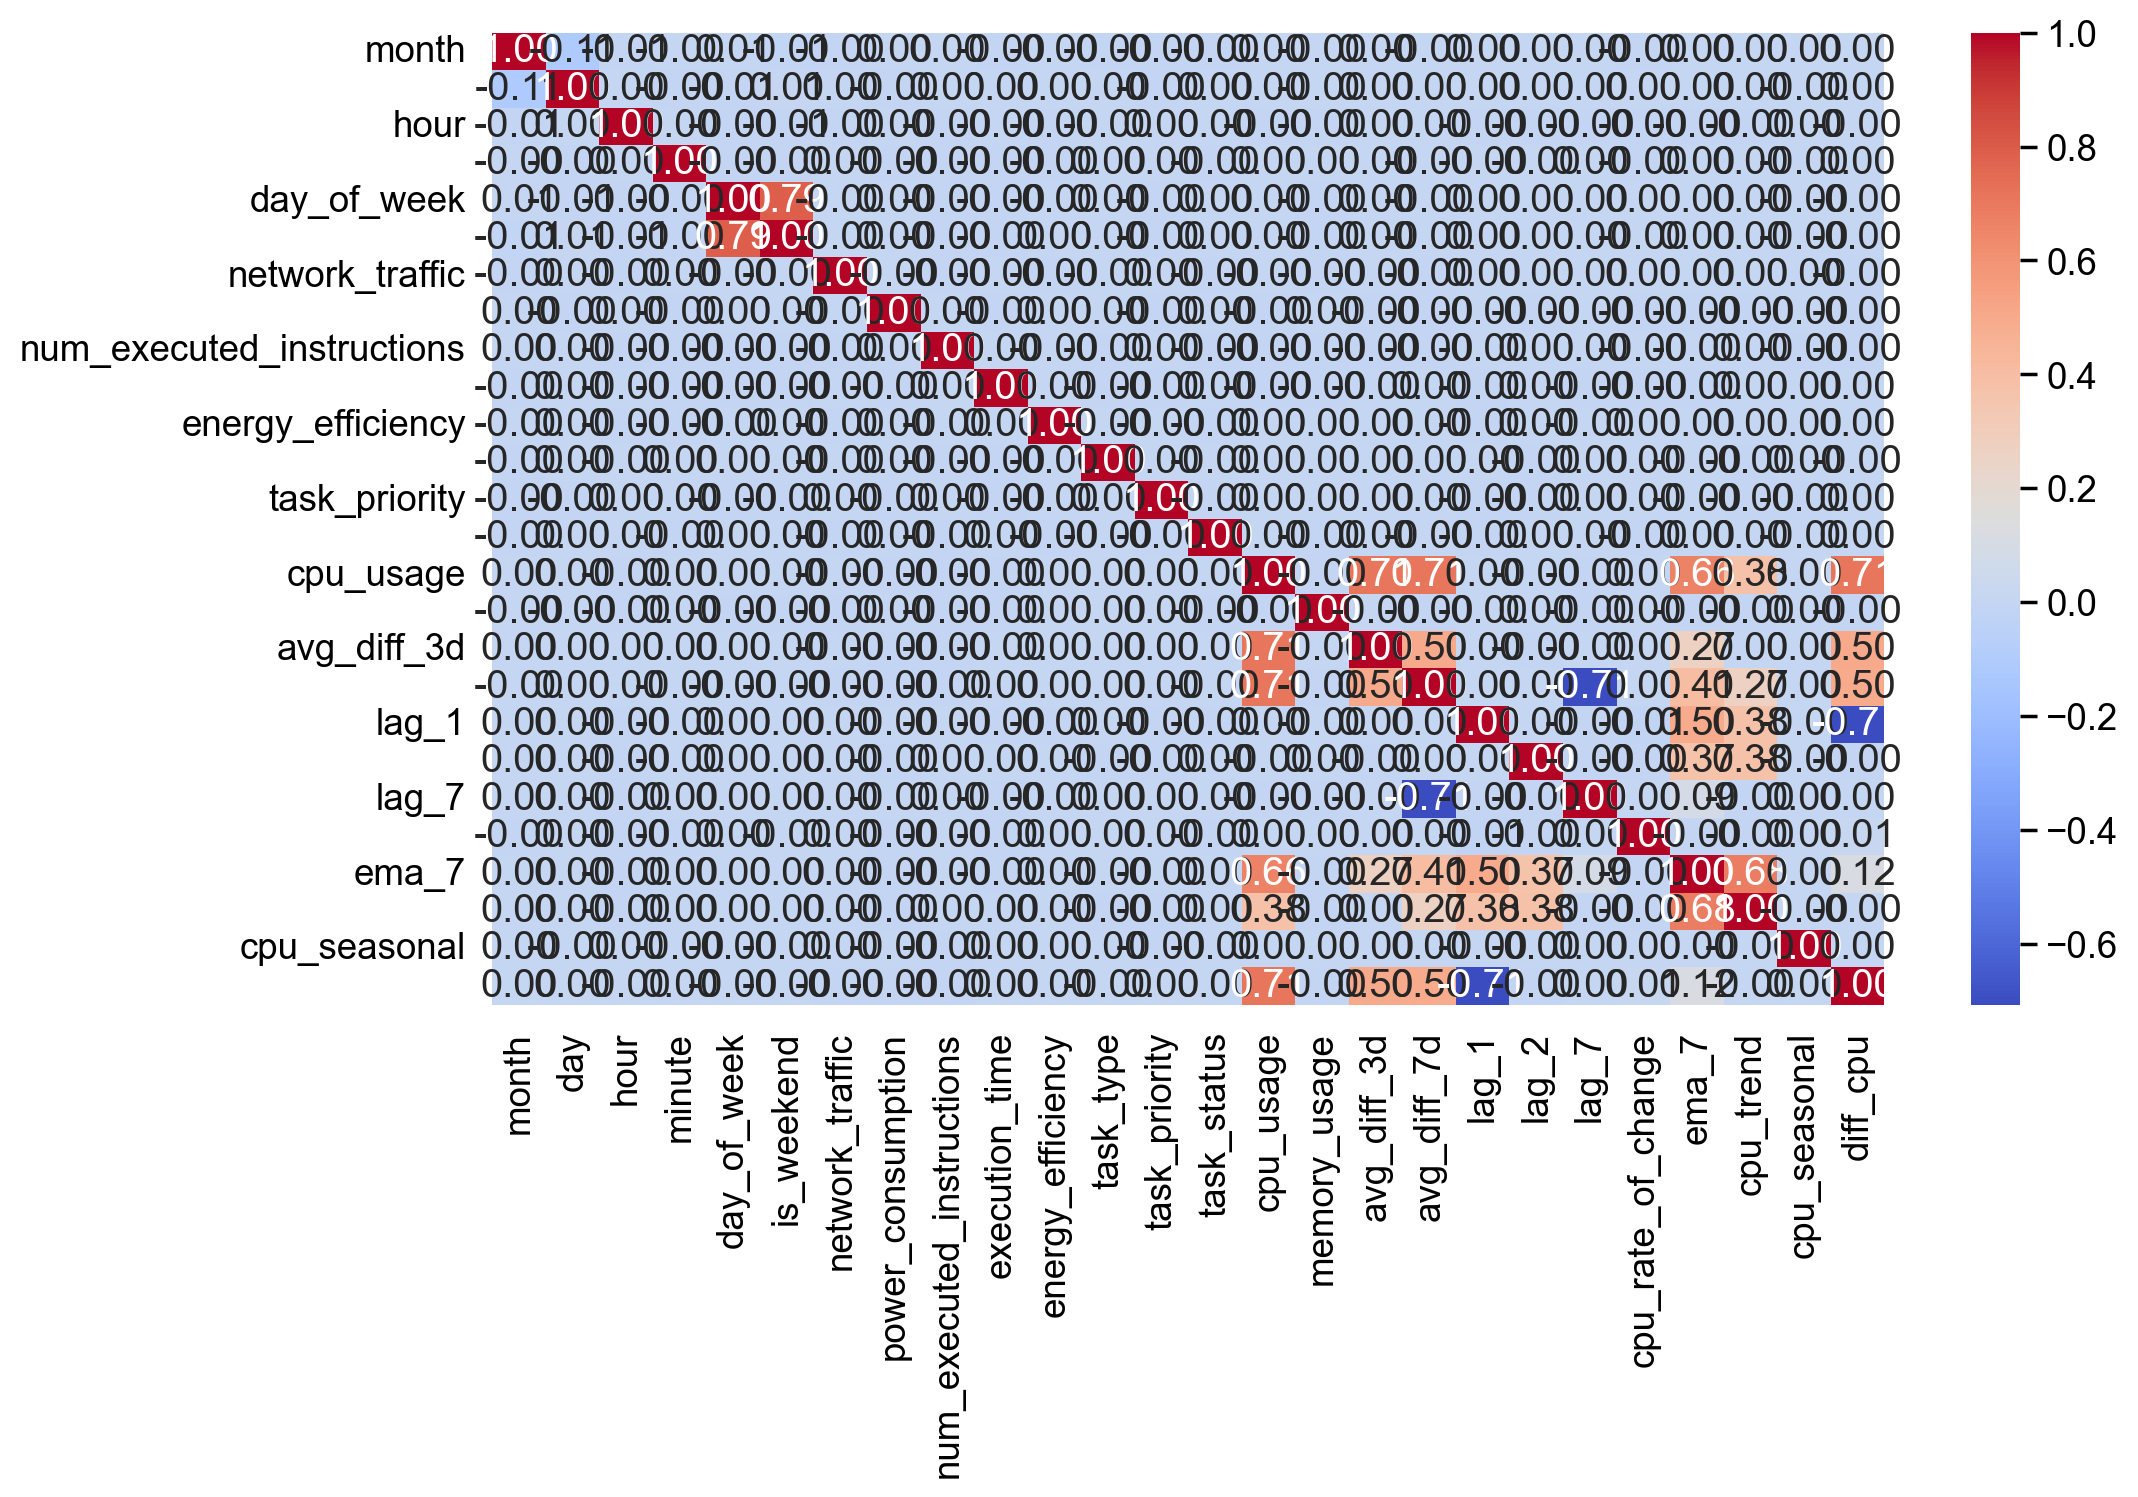

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = train_df_scaled.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

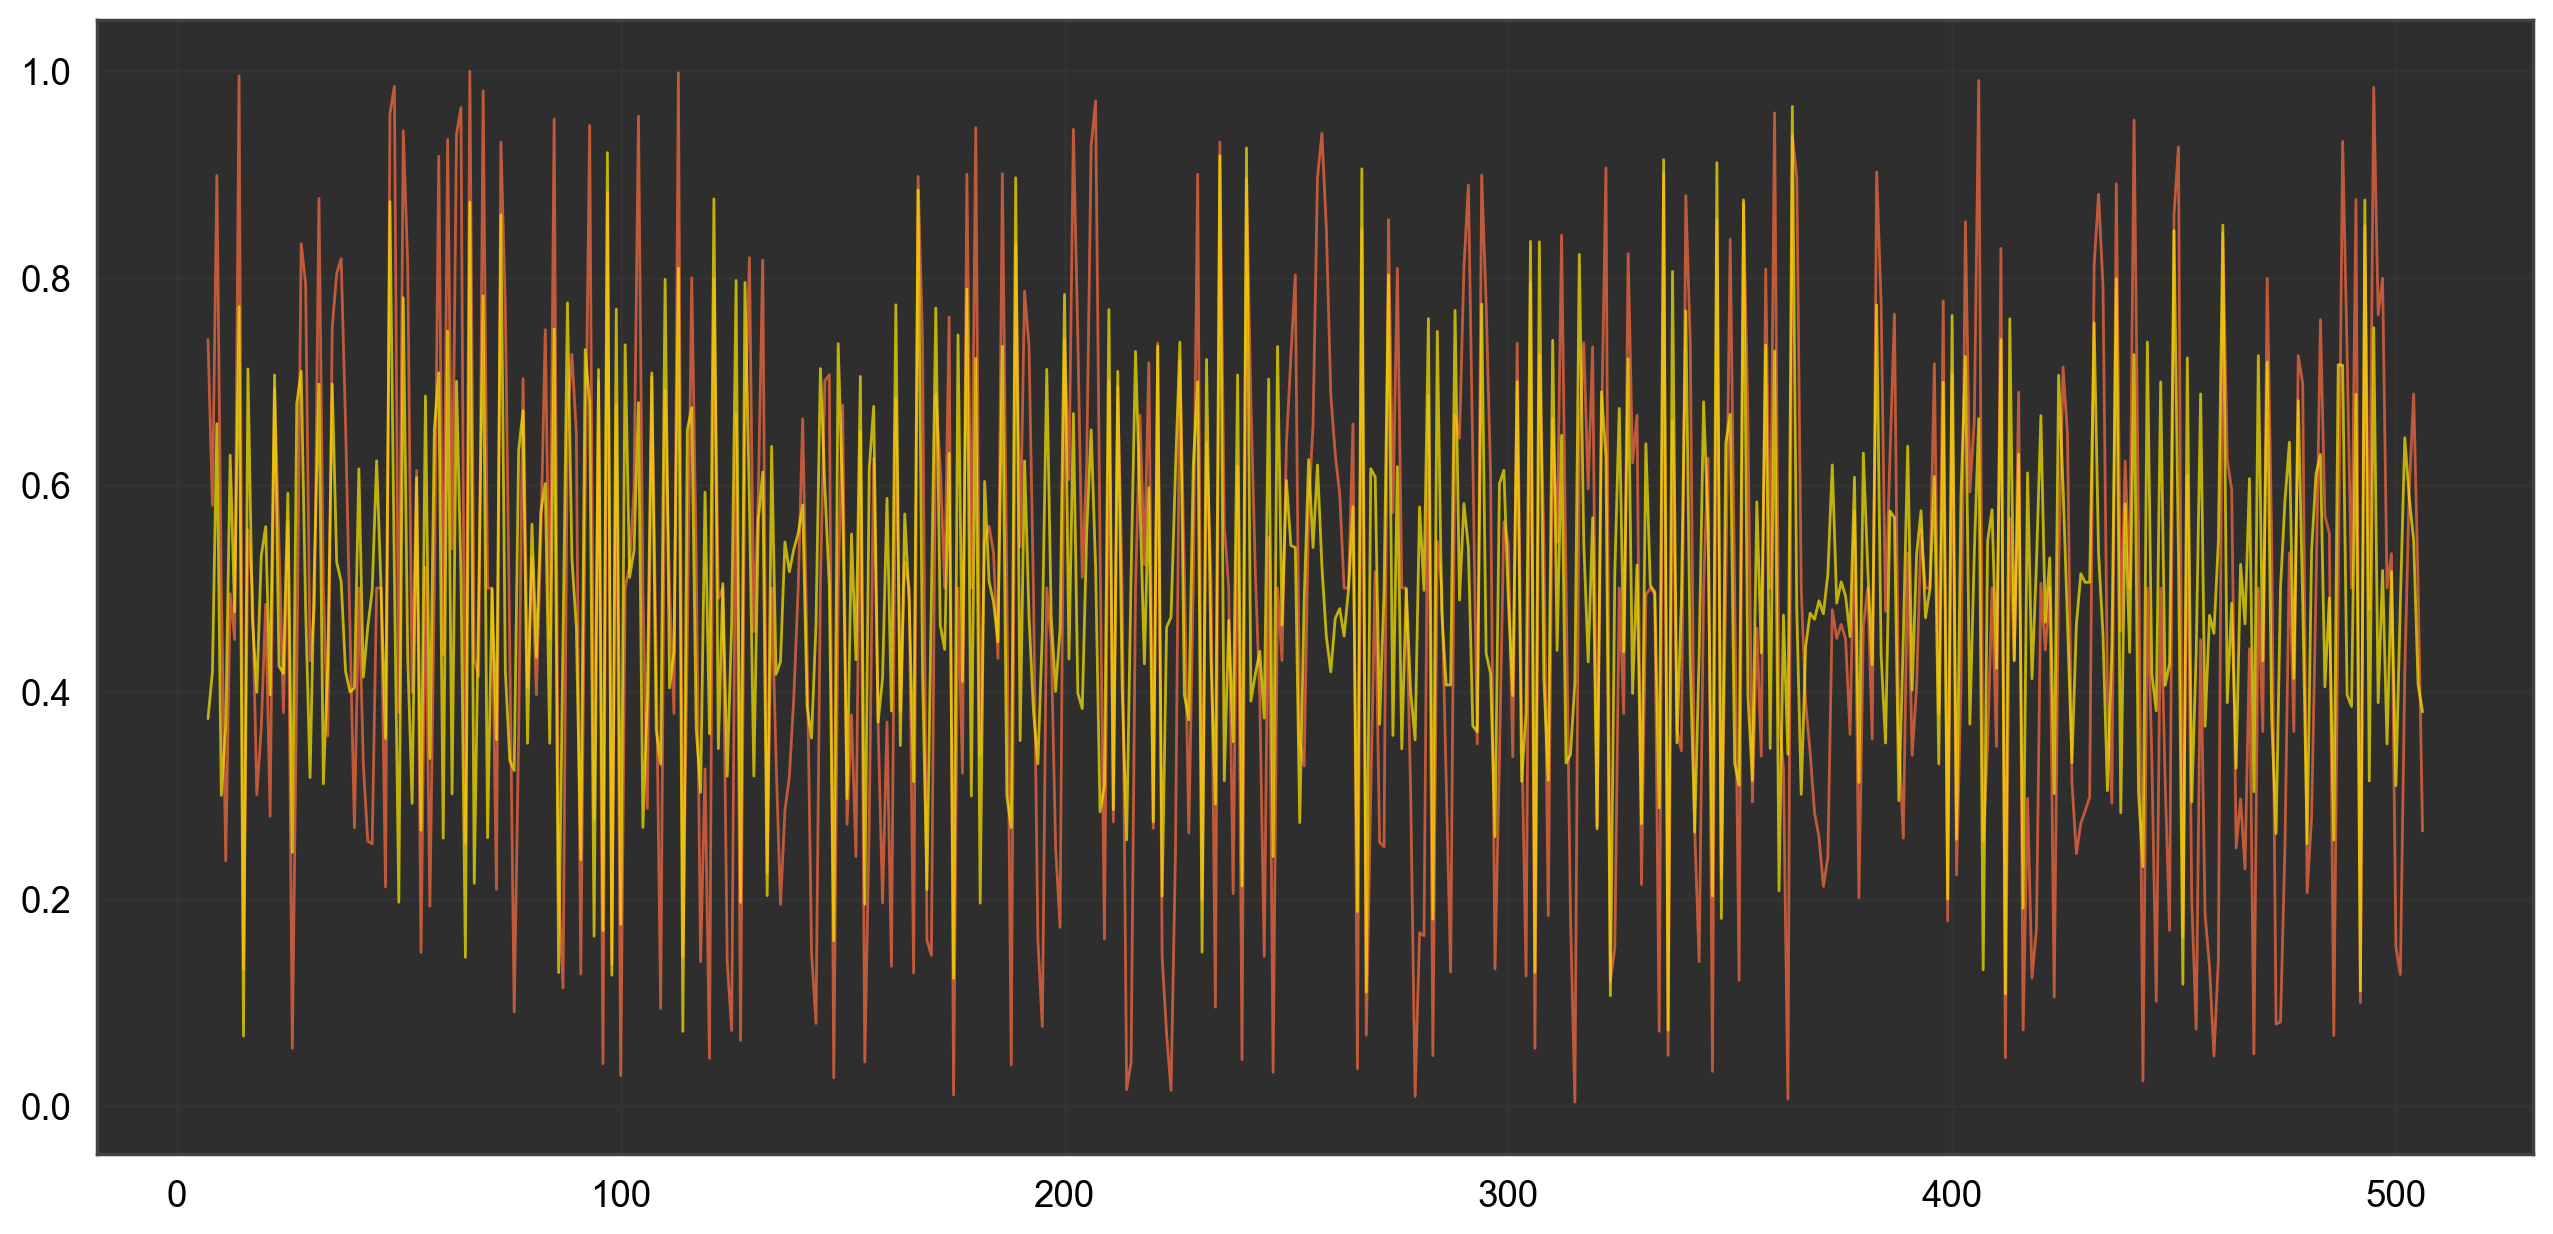

In [17]:
plt.plot(train_df_scaled.iloc[:500]['cpu_usage'], lw=1, alpha=0.7)
plt.plot(train_df_scaled.iloc[:500]['diff_cpu'], lw=1, alpha=0.7)
plt.show()

In [20]:
train_df_scaled.to_csv("../Datasets/preprocessed/VMCloud/train.csv");
test_df_scaled.to_csv("../Datasets/preprocessed/VMCloud/test.csv");